# Symmetrical components

Electrical power systems are often composed of three phases, i.e.: three sinusoidal waves delayed by 1/3 of a cycle between each other. This allows for the a constant power delivery with alternating voltage and current. Those three phases are designated A, B and C.

This article shows how to present and manage such signals in a jupyter notebook, and will present how a three phase unbalanced circuit is derived into three balanced components - symmetrical components - to facilitate analysis.

> Talk a bit more about the technical side of things, or at least refer another guide that's really focused on the technical aspects.

## Requirements

> jupyterlab / notebook (optional), numpy & matplotlib (pip).

## Balanced 3-phase signal

First, the more-than-popular [NumPy](https://numpy.org/) library is required, in addition to [Matplotlib](https://matplotlib.org/) for visualization:

In [2]:
import numpy as np
import matplotlib.pyplot as plt

After setting some parameters, we'll use a basic logic - which will be improved later - to plot a basic balanced, 3-phase signal over a full cycle:

In [3]:
frequency = 60   # Hz
samples = 1000   # Unitless
amplitude = 100  # Amperes

`numpy.linspace` is really conventient to create time periods over the desired range, with the desired number of samples:

In [4]:
# Time domain
t = np.linspace(0, 1 / frequency, samples)

In [5]:

# Currents for phases A, B and C
Ia = amplitude * np.sin(2 * np.pi * frequency * t)
Ib = amplitude * np.sin(2 * np.pi * frequency * t + (2 * np.pi / 3))
Ic = amplitude * np.sin(2 * np.pi * frequency * t + (4 * np.pi / 3))

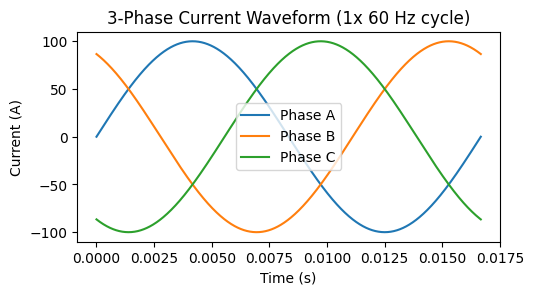

In [6]:
# Plot the time-domain waveform over 1 cycle
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
t = np.linspace(0, 1 / frequency, samples)

plt.plot(t, Ia, label='Phase A')
plt.plot(t, Ib, label='Phase B')
plt.plot(t, Ic, label='Phase C')

plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title(f"3-Phase Current Waveform (1x {frequency} Hz cycle)")
plt.legend()

As I mentioned above, this allows us to transfer *constant power* with alternative current.

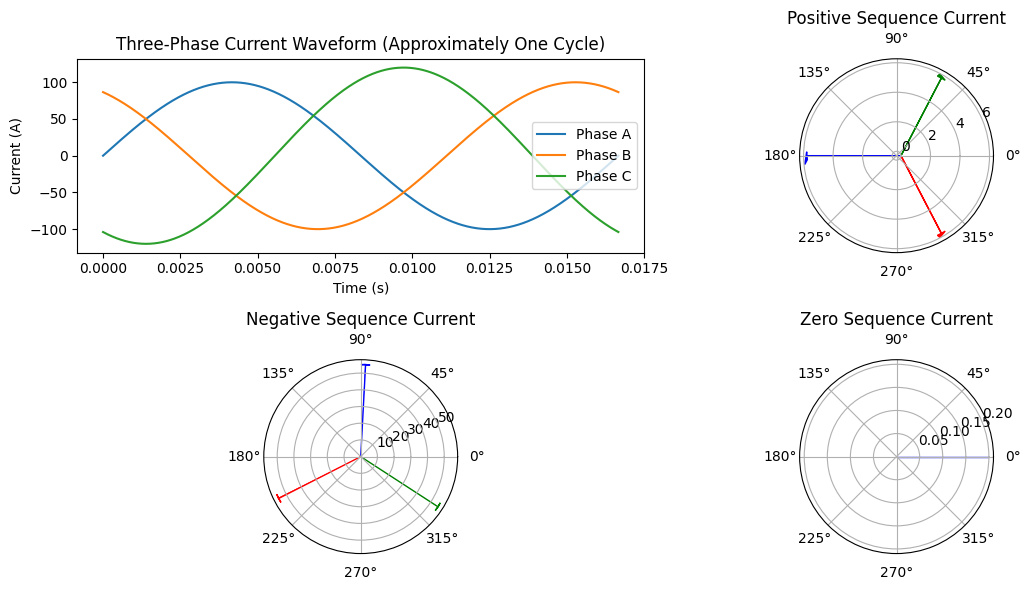

In [7]:

# Function to generate unbalanced three-phase current waveform
def three_phase_current(amplitude, imbalance, samples, frequency):
    t = np.linspace(0, 1 / frequency, samples)
    Ia = amplitude * np.sin(2 * np.pi * frequency * t)
    Ib = amplitude * np.sin(2 * np.pi * frequency * t + (2 * np.pi / 3))
    Ic = amplitude * (1 + imbalance) * np.sin(2 * np.pi * frequency * t + (4 * np.pi / 3))
    return Ia, Ib, Ic

# Generate unbalanced three-phase current waveform
frequency = 60  # Hz
samples = 1000
amplitude = 100
imbalance = 0.2

Ia, Ib, Ic = three_phase_current(amplitude, imbalance, samples, frequency)

# Calculate symmetrical components at time=0
Ipos = (1 / 3) * (Ia[0] + Ib[0] + Ic[0])
Ineg = (1 / 3) * (Ia[0] + np.exp(2j * np.pi / 3) * Ib[0] + np.exp(-2j * np.pi / 3) * Ic[0])
Izero = (1 / 3) * (Ia[0] + Ib[0] + Ic[0]) - Ipos

# Plot the time-domain waveform (approximately one cycle)
plt.figure(figsize=(12, 6))
plt.subplot(2, 2, 1)
t = np.linspace(0, 1 / frequency, samples)
plt.plot(t, Ia, label='Phase A')
plt.plot(t, Ib, label='Phase B')
plt.plot(t, Ic, label='Phase C')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Three-Phase Current Waveform (Approximately One Cycle)')
plt.legend()

# Plot the positive sequence current phasors on a polar plot
plt.subplot(2, 2, 2, polar=True)
plt.title('Positive Sequence Current')
plt.arrow(0, 0, np.angle(Ipos), np.abs(Ipos), head_width=0.1, head_length=0.2, fc='b', ec='b')
plt.arrow(0, 0, np.angle(Ipos * np.exp(2j * np.pi / 3)), np.abs(Ipos), head_width=0.1, head_length=0.2, fc='r', ec='r')
plt.arrow(0, 0, np.angle(Ipos * np.exp(-2j * np.pi / 3)), np.abs(Ipos), head_width=0.1, head_length=0.2, fc='g', ec='g')

# Plot the negative sequence current phasors on a polar plot
plt.subplot(2, 2, 3, polar=True)
plt.title('Negative Sequence Current')
plt.arrow(0, 0, np.angle(Ineg), np.abs(Ineg), head_width=0.1, head_length=0.2, fc='b', ec='b')
plt.arrow(0, 0, np.angle(Ineg * np.exp(2j * np.pi / 3)), np.abs(Ineg), head_width=0.1, head_length=0.2, fc='r', ec='r')
plt.arrow(0, 0, np.angle(Ineg * np.exp(-2j * np.pi / 3)), np.abs(Ineg), head_width=0.1, head_length=0.2, fc='g', ec='g')

# Plot the zero sequence current phasor on a polar plot
plt.subplot(2, 2, 4, polar=True)
plt.title('Zero Sequence Current')
plt.arrow(0, 0, np.angle(Izero), np.abs(Izero), head_width=0.1, head_length=0.2, fc='b', ec='b')

# Adjust the layout
plt.tight_layout()

# Save the figure as a PNG image
plt.savefig('current_waveform.png')
plt.show()


> Show at least 1 or 2 examples using `energy_tools`, especially the `Phasor`.